# Pipeline
 This pipeline should pipe an image through the localization model and the recognition model to first localize a sign in the image and then decide which sign it is. 

In [1]:
import dlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
from pathlib import Path
import pandas as pd
from IPython.display import display

Utilities

In [2]:
__current_directory = Path(os.getcwd())
dataset_path = os.path.join(__current_directory.parent.parent, "FullIJCNN2013")
__resources_directory = os.path.join(__current_directory.parent, "resources")
splits_directory = os.path.join(__resources_directory, "splits")
models_directory = os.path.join(__resources_directory, "models")
model2_directory = os.path.join(__resources_directory, "model2")
results_directory = os.path.join(__resources_directory, "results")

In [3]:
def square_distance(v1: tuple, v2: tuple):
    dx = v1[0] - v2[0]
    dy = v1[1] - v2[1]
    return dx * dx + dy * dy

categories = {
    "prohibitory": [
        0,
        1,
        2,
        3,
        4,
        5,
        7,
        8,
        9,
        10,
        15,
        16,
    ],  # prohibitory, circular, double edge + priority road
    "mandatory": [33, 34, 35, 36, 37, 38, 39, 40],  # mandatory, circular, single edge
    "danger": [
        11,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
    ],  # danger, upward triangle, double edge
    "restriction_ends": [
        6,
        32,
        41,
        42,
    ],  # other/restriction ends, circular, single edge
    "give_way": [13],  # other/give way, rectangular, single edge
    "stop": [14],  # other/stop, octagonal, single edge
    "no_entry": [17],  # other/no entry, single edge
    "priority_road": [12] # other/priority road, diamond, double edge
}

id_label_str = {
    0: 'speed limit 20 (prohibitory)',
    1: 'speed limit 30 (prohibitory)',
    2: 'speed limit 50 (prohibitory)',
    3: 'speed limit 60 (prohibitory)',
    4: 'speed limit 70 (prohibitory)',
    5: 'speed limit 80 (prohibitory)',
    6: 'restriction ends 80 (other)',
    7: 'speed limit 100 (prohibitory)',
    8: 'speed limit 120 (prohibitory)',
    9: 'no overtaking (prohibitory)',
    10: 'no overtaking (trucks) (prohibitory)',
    11: 'priority at next intersection (danger)',
    12: 'priority road (other)',
    13: 'give way (other)',
    14: 'stop (other)',
    15: 'no traffic both ways (prohibitory)',
    16: 'no trucks (prohibitory)',
    17: 'no entry (other)',
    18: 'danger (danger)',
    19: 'bend left (danger)',
    20: 'bend right (danger)',
    21: 'bend (danger)',
    22: 'uneven road (danger)',
    23: 'slippery road (danger)',
    24: 'road narrows (danger)',
    25: 'construction (danger)',
    26: 'traffic signal (danger)',
    27: 'pedestrian crossing (danger)',
    28: 'school crossing (danger)',
    29: 'cycles crossing (danger)',
    30: 'snow (danger)',
    31: 'animals (danger)',
    32: 'restriction ends (other)',
    33: 'go right (mandatory)',
    34: 'go left (mandatory)',
    35: 'go straight (mandatory)',
    36: 'go right or straight (mandatory)',
    37: 'go left or straight (mandatory)',
    38: 'keep right (mandatory)',
    39: 'keep left (mandatory)',
    40: 'roundabout (mandatory)',
    41: 'restriction ends (overtaking) (other)',
    42: 'restriction ends (overtaking (trucks)) (other)',
}

class ResultBox:
    def __init__(self, top, left, width, height, locator_confidence, locator_label, labelled_center):
        self.top_ = top
        self.left_ = left
        self.width = width
        self.height = height
        self.locator_confidence = locator_confidence
        self.center = (top + height // 2, left + width // 2)
        self.square_distance = square_distance(self.center, labelled_center)
        self.locator_label = locator_label
        self.recognition_label_id = -1
        self.recognition_confidence = 0
        
    def left(self):
        return self.left_
    def top(self):
        return self.top_
    def right(self):
        return self.left_ + self.width
    def bottom(self):
        return self.top_ + self.height
    def label(self):
        return id_label_str[self.recognition_label_id] + f' ({self.recognition_label_id})'
    
    def __str__(self):
        return (f"ResultBox(box({self.top()}, {self.left()}, {self.right()}, "
                f"{self.bottom()}), center={self.center}, "
                f"confidence={self.locator_confidence:.2f}, square_distance={self.square_distance}, "
                f"locator_label='{self.locator_label}', recognition_label='{self.label()}')")
    
class ImageData:
    def __init__(self, file, label, top, left, width, height):
        self.file = file
        self.label_id = label
        self.top_ = top
        self.left_ = left
        self.width = width
        self.height = height
        self.center = (top + height // 2, left + width // 2)
        self.result_boxes = []
        
    def left(self):
        return self.left_
    def top(self):
        return self.top_
    def right(self):
        return self.left_ + self.width
    def bottom(self):
        return self.top_ + self.height
    def label(self):
        return id_label_str[self.label_id] + f' ({self.label_id})'
    def locator_category(self):
        for category in categories:
            if self.label_id in categories[category]:
                return category
        return "Error"
    def __str__(self):
        result_boxes_str = "\n  ".join(str(rb) for rb in self.result_boxes)
        return (f"ImageData(file='{self.file}', label='{self.label()}', "
                f"box=({self.top_}, {self.left_}, {self.left_ + self.width}, "
                f"{self.top_ + self.height}), center={self.center}, "
                f"result_boxes=[\n  {result_boxes_str}\n])")
        

## Import the images

In [4]:
image_dataset = []

xml_files = [ os.path.join(splits_directory, file) for file in os.listdir(splits_directory) if '-test_' in file]
for xml_file in xml_files:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for image_node in root.findall('.//image'):
        file = image_node.get('file')
        label = int(image_node.find('label').text)
        box_node = image_node.find('box')
        top = int(box_node.get('top'))
        left = int(box_node.get('left'))
        width = int(box_node.get('width'))
        height = int(box_node.get('height'))
        
        image_dataset.append(ImageData(file, label, top, left, width, height))
    
def clear_results(dataset):
    for image_data in dataset:
        image_data.result_boxes = []

## Load the models 

In [5]:
location_detectors = {
    model[6:-4]: dlib.simple_object_detector(os.path.join(models_directory, model))
    for model in os.listdir(models_directory)
}

## Load the image 

In [6]:
def load_image(image_data):
    # The image we want to get the signs for
    img = cv2.imread(image_data.file)    
    return img

In [7]:
def apply_detectors_to_image(image_data, detectors, img):
    # apply the model to the image
    boxes, confidences, detector_idxs = dlib.simple_object_detector.run_multiple(
        list(detectors.values()), img, upsample_num_times=1, adjust_threshold=0.0
    )
    for i in range(len(boxes)): # first only calculate values and such
        box = boxes[i]
        image_data.result_boxes.append(ResultBox(
            box.top(), 
            box.left(), 
            box.right() - box.left(), 
            box.bottom() - box.top(), 
            confidences[i],       
            list(detectors.keys())[detector_idxs[i]],
            image_data.center,
        ))

## Recognition

### Prepare the images

In [8]:
def crop_and_resize_box(box, img):
    cropped_image = img[box.top():box.bottom(), box.left():box.right()]
    resized_image = cv2.resize(cropped_image, (64, 64))
    resized_image = np.expand_dims(resized_image, axis=0)
    return resized_image

## Load the model

In [9]:
recognition_model = tf.keras.models.load_model(os.path.join(model2_directory, "final_model.h5"), compile=False)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Predict the sign

In [10]:
def predict_class_id(model, img):
    #predict
    predictions = model.predict(img)
    # choose the one with the highest probability
    prediction_idx = np.argmax(predictions[0]) # equals label
    conf = predictions[0][prediction_idx]
    return prediction_idx, conf

## Run and collect results

In [11]:
clear_results(image_dataset)
for image_data in image_dataset:
    img = cv2.imread(image_data.file)
    apply_detectors_to_image(image_data, location_detectors, img)
    for box in image_data.result_boxes:
        resized_image = crop_and_resize_box(box, img)
        id, conf = predict_class_id(recognition_model, resized_image)
        box.recognition_label_id = id
        box.recognition_confidence = conf


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [12]:
confidence_threshold = 0.5
square_distance_threshold = 10

In [13]:
data = []

for image_data in image_dataset:
    for result_box in image_data.result_boxes:
        data.append({
            "File": image_data.file,
            "Label": image_data.label(),
            "Label_Short": image_data.locator_category(),
            "Box_Size": image_data.width * image_data.height,
            "Recog_Label": result_box.label(),
            "Recog_Confidence": result_box.recognition_confidence,
            "Locator_Label": result_box.locator_label,
            "Locator_Confidence": result_box.locator_confidence,
            "Square_Distance": result_box.square_distance,
            "Located_Size": result_box.width * result_box.height,
            "located_correctly": result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold,
            "labelled_correctly": result_box.recognition_label_id == image_data.label_id and result_box.recognition_confidence > confidence_threshold if result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold else 'agree' if result_box.recognition_label_id in categories[result_box.locator_label] else 'disagree',
        })

df = pd.DataFrame(data)
display(df)

File  \
0    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00265.jpg   
1    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00763.jpg   
2    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00763.jpg   
3    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00763.jpg   
4    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00697.jpg   
..                                                ...   
293  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00548.jpg   
294  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00548.jpg   
295  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00688.jpg   
296  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00688.jpg   
297  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00688.jpg   

                                           Label Label_Short  Box_Size  \
0                     road narrows (danger) (24)      danger       930   
1    priority at next intersection (danger) (11)      danger      1287   
2    priority at next intersection (danger) (11)      danger      1287   
3    priority at next intersection (danger) (11)      danger      1287   
4                     construction (danger) (25)      danger      5092   
..                                           ...         ...       ...   
293                            stop (other) (14)        stop      1296   
294                            stop (other) (14)        stop      1296   
295                            stop (other) (14)        stop      1296   
296                            stop (other) (14)        stop      1296   
297                            stop (other) (14)        stop      1296   

                                     Recog_Label  Recog_Confidence  \
0                     road narrows (danger) (24)          0.999864   
1    priority at next intersection (danger) (11)          0.999986   
2                      go right (mandatory) (33)          0.293707   
3                  restriction ends (other) (32)          0.999659   
4                     construction (danger) (25)          0.998585   
..                                           ...               ...   
293                 go straight (mandatory) (35)          0.371629   
294                            stop (other) (14)          0.993814   
295                            stop (other) (14)          0.932149   
296                     bend right (danger) (20)          0.496001   
297                     bend right (danger) (20)          0.496001   

        Locator_Label  Locator_Confidence  Square_Distance  Located_Size  \
0              danger            0.229567                5          1280   
1              danger            1.068145                1          1280   
2              danger            0.146013           254858          1824   
3    restriction_ends            0.041403           142906          1849   
4              danger            1.066328               10          3795   
..                ...                 ...              ...           ...   
293       prohibitory            0.438022            45736          1296   
294       prohibitory            0.112608                8          1296   
295              stop            0.956757                1          1296   
296       prohibitory            0.813316            31268          2652   
297         mandatory            0.077173            31268          2652   

     located_correctly labelled_correctly  
0                False              agree  
1                 True               True  
2                False           disagree  
3                False              agree  
4                False              agree  
..                 ...                ...  
293              False           disagree  
294              False           disagree  
295               True               True  
296              False           disagree  
297              False           disagree  

[298 rows x 12 columns]

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df["Label_Short"], df["Locator_Label"])

array([[33,  1,  2,  0,  0,  6,  7,  0],
       [ 1, 11,  4,  0,  0,  5,  2,  1],
       [ 1,  3, 20,  2,  4, 16,  3,  4],
       [ 0,  0,  4,  2,  0,  5,  1,  0],
       [ 1,  0,  2,  0, 13,  6,  3,  1],
       [ 8,  1, 13,  0,  7, 73, 10,  5],
       [ 0,  0,  1,  0,  0,  1,  6,  0],
       [ 0,  0,  2,  0,  0,  4,  0,  3]], dtype=int64)

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score(df["Label_Short"], df["Locator_Label"])

0.540268456375839

In [16]:
confusion_matrix(df["Label"], df["Recog_Label"])

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 2, ..., 6, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 3]], dtype=int64)

In [17]:
accuracy_score(df["Label"], df["Recog_Label"]) # these includes boxes that aren't labelled, which could be correctly predicted but have the wrong label here 

0.5503355704697986

In [18]:
display(df['located_correctly'].value_counts(normalize=True))
df_confident = df.drop(df[df['located_correctly'] == False].index)
display(df_confident['labelled_correctly'].value_counts(normalize=True))

recog_falsch = df_confident.drop(df_confident[df_confident['labelled_correctly']].index)

located_correctly
False    0.771812
True     0.228188
Name: proportion, dtype: float64

labelled_correctly
True     0.823529
False    0.176471
Name: proportion, dtype: float64

In [44]:
only_located_correct = [] # Every image once, only the most confident result or none if there isn't one

for image_data in image_dataset:
    if len(image_data.result_boxes) == 0:
        only_located_correct.append({
                "File": image_data.file,
                "Label": image_data.label(),
                "Label_Short": image_data.locator_category(),
                "Box_Size": image_data.width * image_data.height,
                "Locator_Label": "None",
                "located_correctly": False,
            })
    else:
        result_box = sorted(image_data.result_boxes, key=lambda box: box.locator_confidence, reverse=True)[0]
        if result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold: 
            only_located_correct.append({
                "File": image_data.file,
                "Label": image_data.label(),
                "Label_Short": image_data.locator_category(),
                "Box_Size": image_data.width * image_data.height,
                "Recog_Label": result_box.label(),
                "Recog_Confidence": result_box.recognition_confidence,
                "Locator_Label": result_box.locator_label,
                "Locator_Confidence": result_box.locator_confidence,
                "Square_Distance": result_box.square_distance,
                "Located_Size": result_box.width * result_box.height,
                "located_correctly": result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold,
                "labelled_correctly": result_box.recognition_label_id == image_data.label_id and result_box.recognition_confidence > confidence_threshold if result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold else 'agree' if result_box.recognition_label_id in categories[result_box.locator_label] else 'disagree',
            })
            
only_located_correct_df = pd.DataFrame(only_located_correct)
only_located_correct_df.head()

File  \
0  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00763.jpg   
1  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00076.jpg   
2  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00168.jpg   
3  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00492.jpg   
4  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00079.jpg   

                                         Label Label_Short  Box_Size  \
0  priority at next intersection (danger) (11)      danger      1287   
1                           bend (danger) (21)      danger      1120   
2                         danger (danger) (18)      danger       598   
3  priority at next intersection (danger) (11)      danger       870   
4  priority at next intersection (danger) (11)      danger       900   

                                   Recog_Label  Recog_Confidence  \
0  priority at next intersection (danger) (11)          0.999986   
1                           bend (danger) (21)          0.999998   
2                                          NaN               NaN   
3                                          NaN               NaN   
4                                          NaN               NaN   

  Locator_Label  Locator_Confidence  Square_Distance  Located_Size  \
0        danger            1.068145              1.0        1280.0   
1        danger            0.642530              4.0        1280.0   
2          None                 NaN              NaN           NaN   
3          None                 NaN              NaN           NaN   
4          None                 NaN              NaN           NaN   

   located_correctly labelled_correctly  
0               True               True  
1               True               True  
2              False                NaN  
3              False                NaN  
4              False                NaN

In [28]:
accuracy_score(only_located_correct_df["Label_Short"], only_located_correct_df["Locator_Label"])

0.6111111111111112

In [42]:
only_located_nearest = [] # Every image once, only the most confident result or none if there isn't one

for image_data in image_dataset:
    if len(image_data.result_boxes) == 0:
        only_located_nearest.append({
                "File": image_data.file,
                "Label": image_data.label(),
                "Label_Short": image_data.locator_category(),
                "Box_Size": image_data.width * image_data.height,
                "Locator_Label": "None",   
                "located_correctly": False,
            })
    else:
        result_box = sorted(image_data.result_boxes, key=lambda box: box.square_distance)[0]
        if result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold: 
            only_located_nearest.append({
                "File": image_data.file,
                "Label": image_data.label(),
                "Label_Short": image_data.locator_category(),
                "Box_Size": image_data.width * image_data.height,
                "Recog_Label": result_box.label(),
                "Recog_Confidence": result_box.recognition_confidence,
                "Locator_Confidence": result_box.locator_confidence,
                "Locator_Label": result_box.locator_label,
                "Square_Distance": result_box.square_distance,
                "Located_Size": result_box.width * result_box.height,
                "located_correctly": result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold,
                "labelled_correctly": result_box.recognition_label_id == image_data.label_id and result_box.recognition_confidence > confidence_threshold if result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold else 'agree' if result_box.recognition_label_id in categories[result_box.locator_label] else 'disagree',
            })
            
only_located_nearest_df = pd.DataFrame(only_located_nearest)
only_located_nearest_df.head()

File  \
0  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00763.jpg   
1  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00076.jpg   
2  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00168.jpg   
3  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00492.jpg   
4  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00079.jpg   

                                         Label Label_Short  Box_Size  \
0  priority at next intersection (danger) (11)      danger      1287   
1                           bend (danger) (21)      danger      1120   
2                                         None      danger       598   
3                                         None      danger       870   
4                                         None      danger       900   

                                   Recog_Label  Recog_Confidence  \
0  priority at next intersection (danger) (11)          0.999986   
1                           bend (danger) (21)          0.999998   
2                                         None               NaN   
3                                         None               NaN   
4                                         None               NaN   

   Locator_Confidence Locator_Label  Square_Distance  Located_Size  \
0            1.068145        danger              1.0        1280.0   
1            0.642530        danger              4.0        1280.0   
2                 NaN          None              NaN           NaN   
3                 NaN          None              NaN           NaN   
4                 NaN          None              NaN           NaN   

   located_correctly labelled_correctly  
0               True               True  
1               True               True  
2              False                NaN  
3              False                NaN  
4              False                NaN

In [33]:
accuracy_score(only_located_nearest_df["Label_Short"], only_located_nearest_df["Locator_Label"])

0.6534653465346535

In [23]:
not_found_correct = []

for image_data in image_dataset:
    if len(image_data.result_boxes) == 0:
        not_found_correct.append({
            "File": image_data.file,
            "Label": image_data.label(),
            "Box_Size": image_data.width * image_data.height,
        })
    found_any = False
    for result_box in image_data.result_boxes:
        if result_box.square_distance < square_distance_threshold and result_box.locator_confidence > confidence_threshold:
            found_any = True
            break
    if not found_any:
        not_found_correct.append({
        "File": image_data.file,
        "Label": image_data.label(),
        "Box_Size": image_data.width * image_data.height,
    })

not_found_correctly_df = pd.DataFrame(not_found_correct)
display(not_found_correctly_df.describe())
display(not_found_correctly_df)

Box_Size
count    153.000000
mean    1918.529412
std     2516.287862
min      420.000000
25%      624.000000
50%      868.000000
75%     1681.000000
max    13764.000000

File  \
0    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00265.jpg   
1    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00697.jpg   
2    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00168.jpg   
3    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00168.jpg   
4    E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00492.jpg   
..                                                ...   
148  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00789.jpg   
149  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00789.jpg   
150  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00849.jpg   
151  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00842.jpg   
152  E:\DIGITAL TECHNOLOGY\KI\FullIJCNN2013\00548.jpg   

                                           Label  Box_Size  
0                     road narrows (danger) (24)       930  
1                     construction (danger) (25)      5092  
2                           danger (danger) (18)       598  
3                           danger (danger) (18)       598  
4    priority at next intersection (danger) (11)       870  
..                                           ...       ...  
148                            stop (other) (14)       812  
149                            stop (other) (14)       812  
150                            stop (other) (14)      2279  
151                            stop (other) (14)      3721  
152                            stop (other) (14)      1296  

[153 rows x 3 columns]

In [24]:
wrong_datas = []
false_files = recog_falsch['File'].tolist()
for image_data in image_dataset:
    if image_data.file in false_files:
        wrong_datas.append(image_data)
     

In [25]:
def draw_image_with_result_boxes(image_data, img = None):
    if img is None:
        img = cv2.imread(image_data.file)
        
    # draw expected box first 
    cv2.rectangle(img, (image_data.left(), image_data.top()), (image_data.right(), image_data.bottom()), (0, 255, 0), 2)
    for i in range(len(image_data.result_boxes)):
        box = image_data.result_boxes[i]
        label = f"Detector {box.locator_label}: {box.locator_confidence:.2f}"
       
        # Draw bounding box
        cv2.rectangle(img, (box.left(), box.top()), (box.right(), box.bottom()), (0, 0, 255), 2)
        
        # Display label and confidence below the box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7 
        font_thickness = 2 
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x = box.left()
        text_y = box.bottom() + text_size[1] + 5
    
        cv2.putText(img, label, (text_x, text_y), font, font_scale, (0, 0, 255), font_thickness)
    
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
def draw_cropped_boxes(image_data, img = None):
    if img is None:
        img = cv2.imread(image_data.file)
        
    plt.figure(figsize=(12, 7))  
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    
    og = crop_and_resize_box(image_data, img)
    cv2.putText(og.squeeze(), image_data.label(), (5,7), font, font_scale, (0, 255, 0), font_thickness)
    plt.subplot(1, len(image_data.result_boxes) + 1, 1)
    plt.imshow(og.squeeze())
    plt.axis('off')  
    
    for i in range(len(image_data.result_boxes)):
        box = image_data.result_boxes[i]
        resized_image = crop_and_resize_box(box, img)
        cv2.putText(resized_image.squeeze(), box.label(), (5,7), font, font_scale, (0, 255, 0), font_thickness)
        plt.subplot(1, len(image_data.result_boxes) + 1, i+2)
        plt.imshow(resized_image.squeeze())
        plt.axis('off')  
    plt.show()

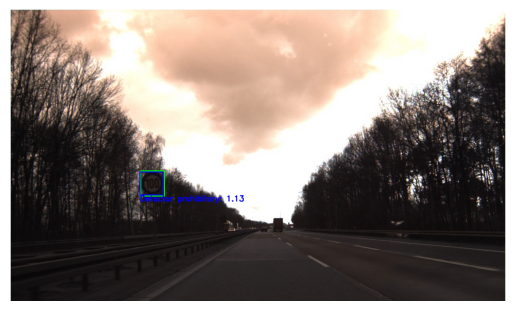

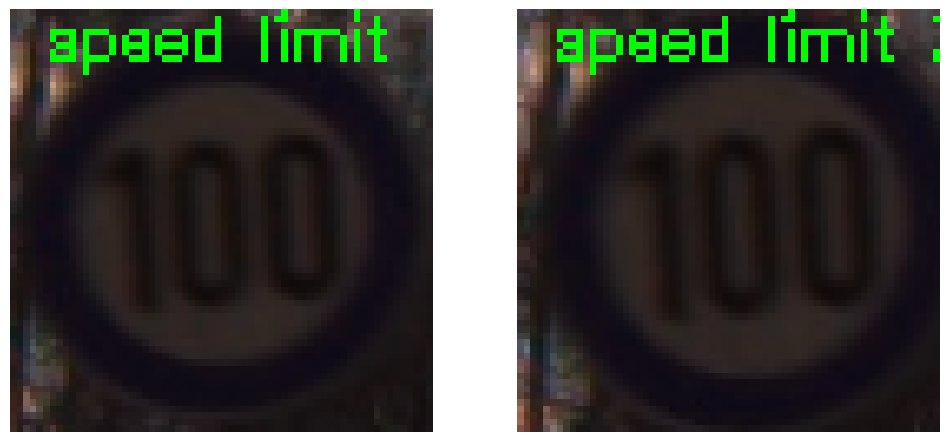

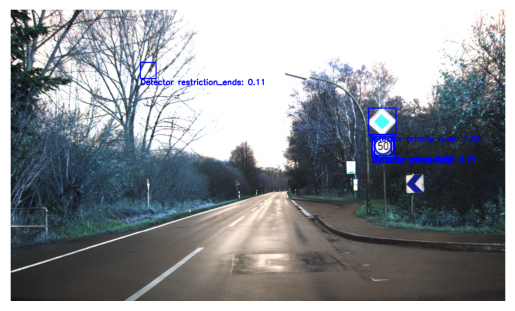

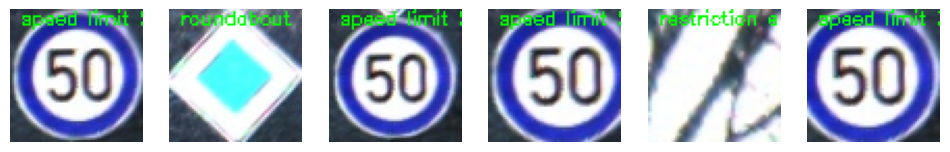

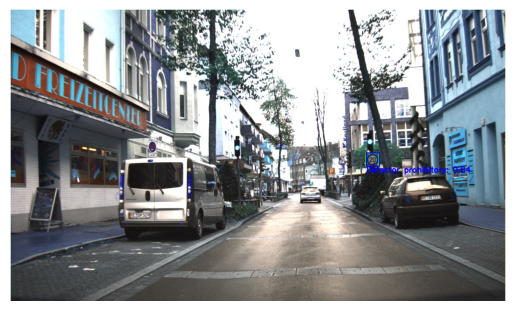

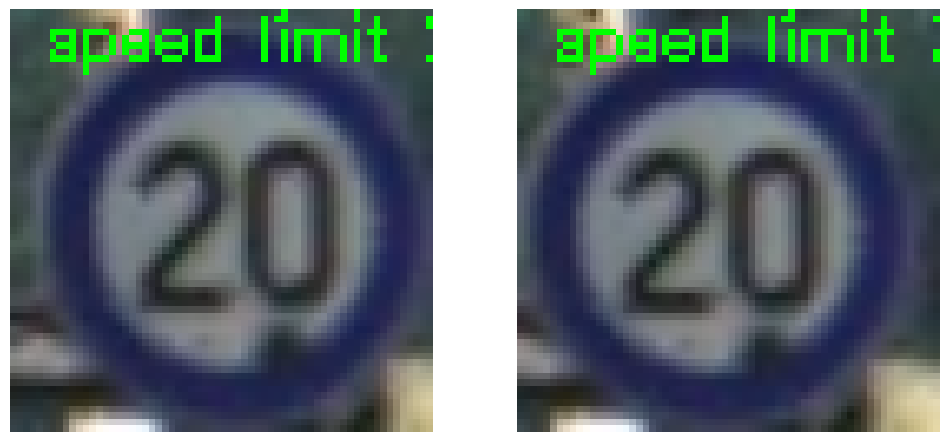

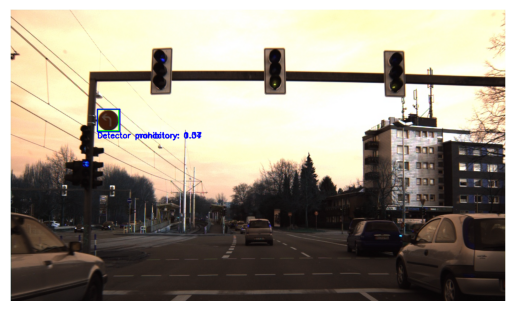

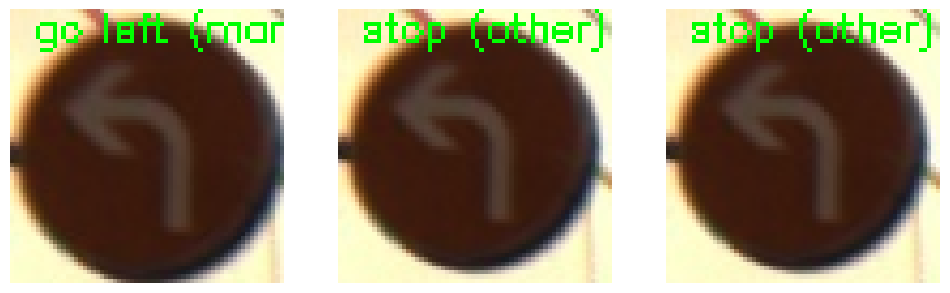

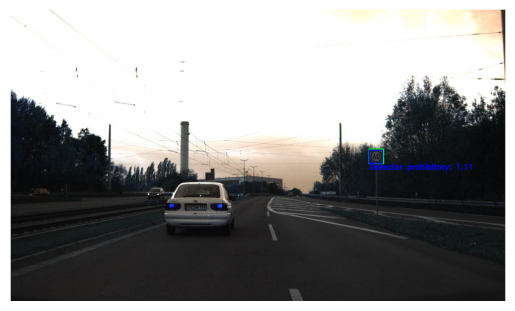

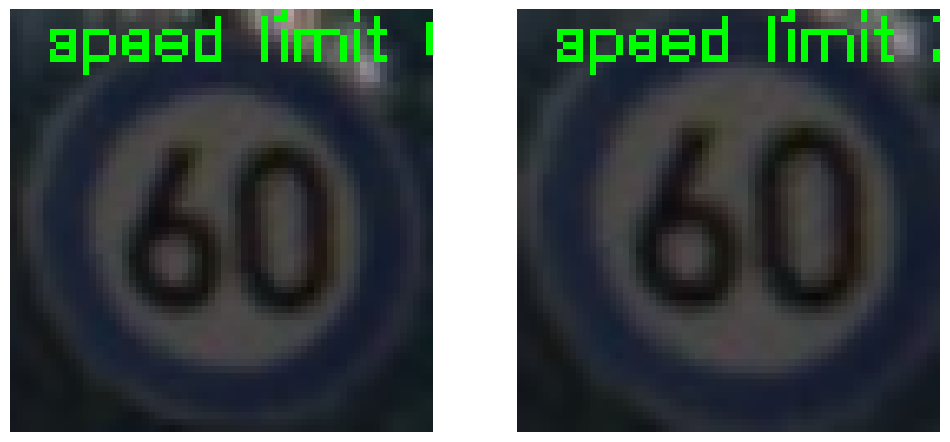

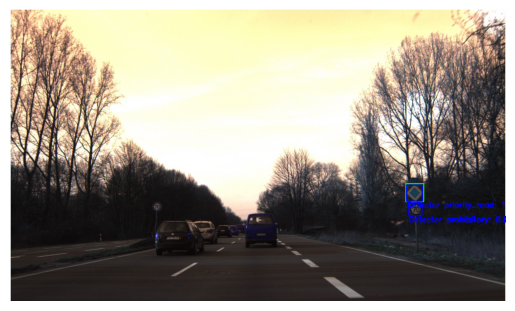

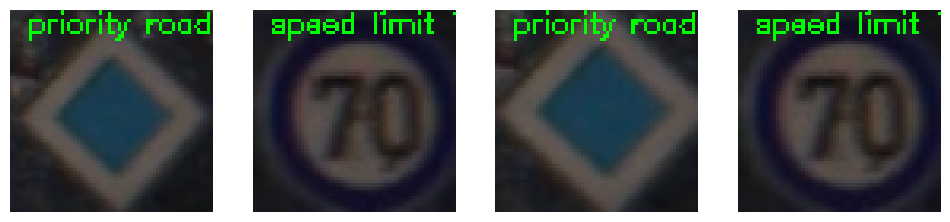

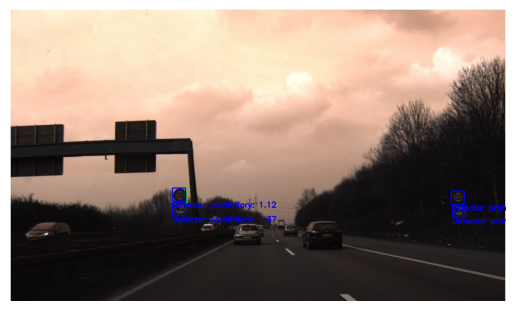

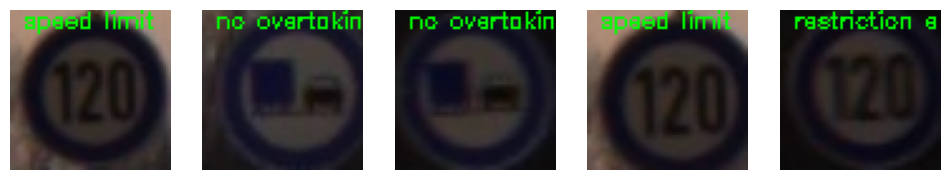

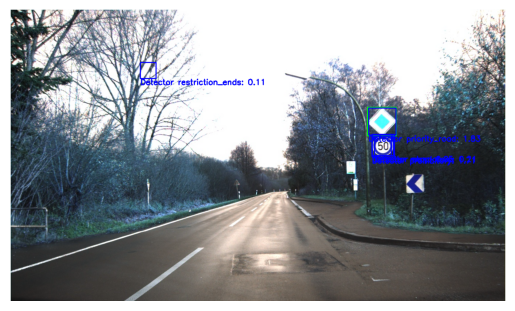

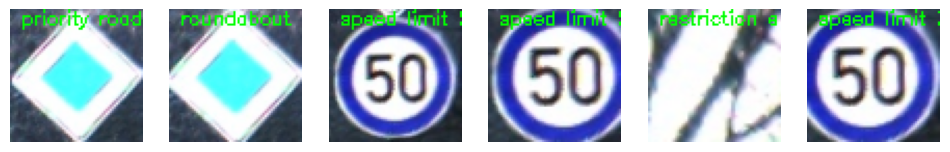

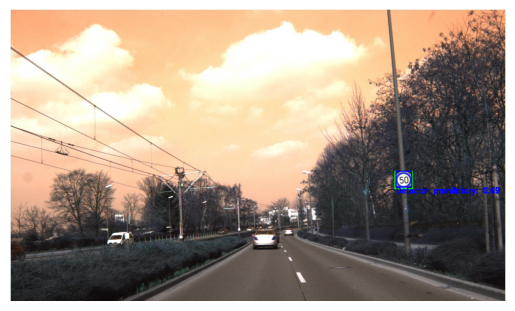

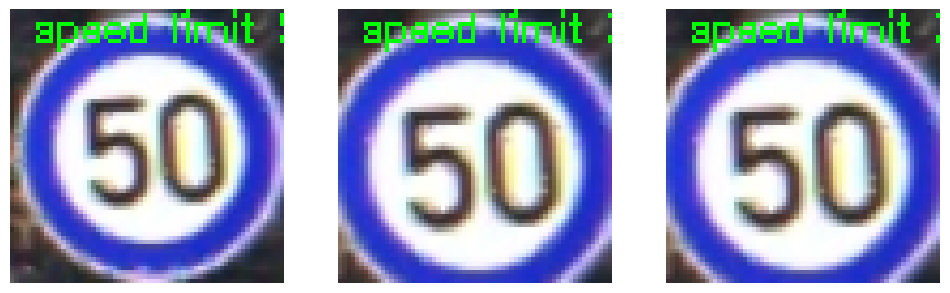

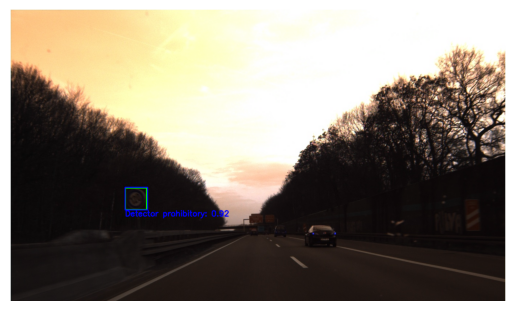

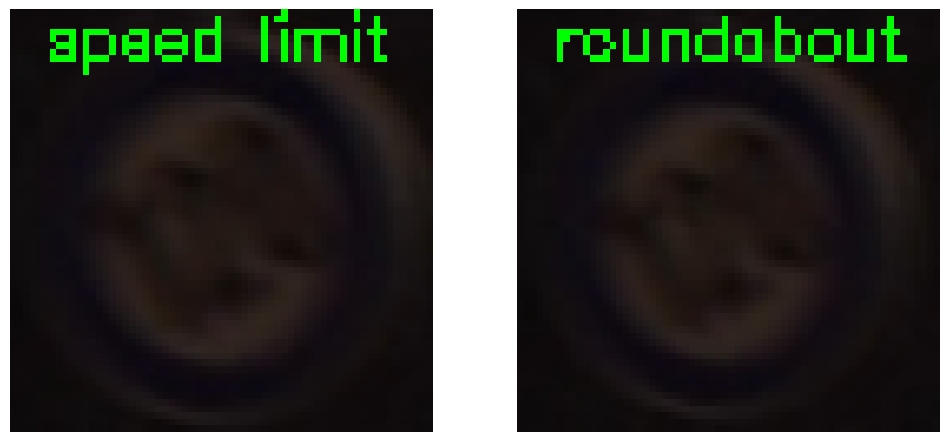

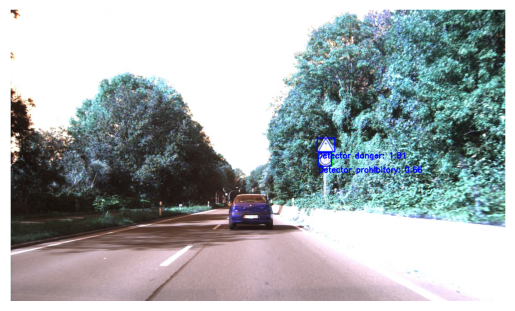

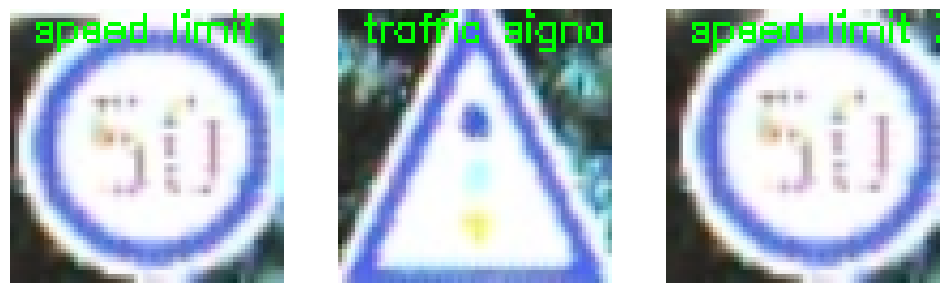

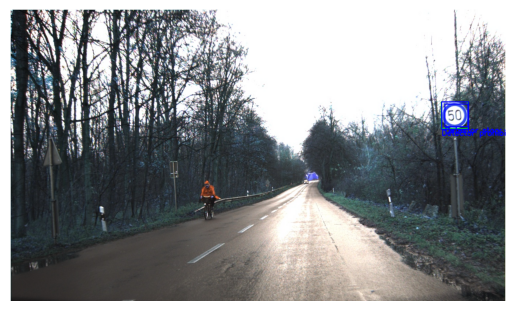

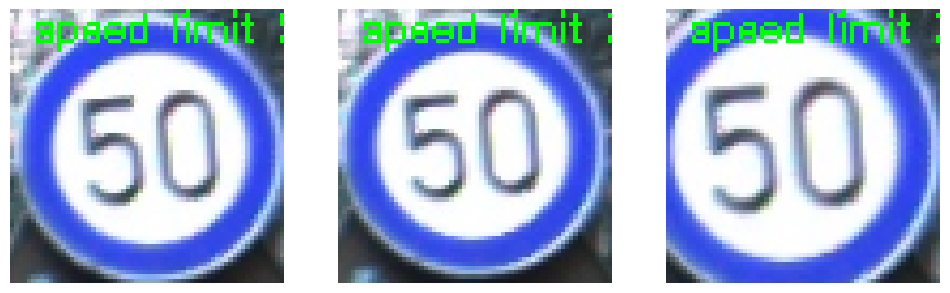

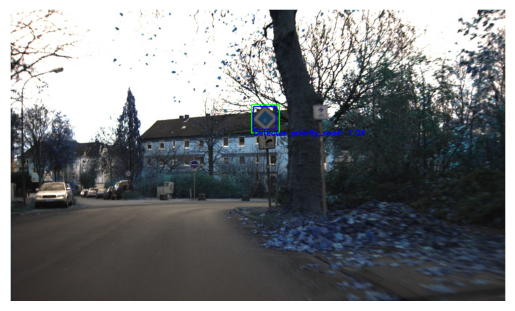

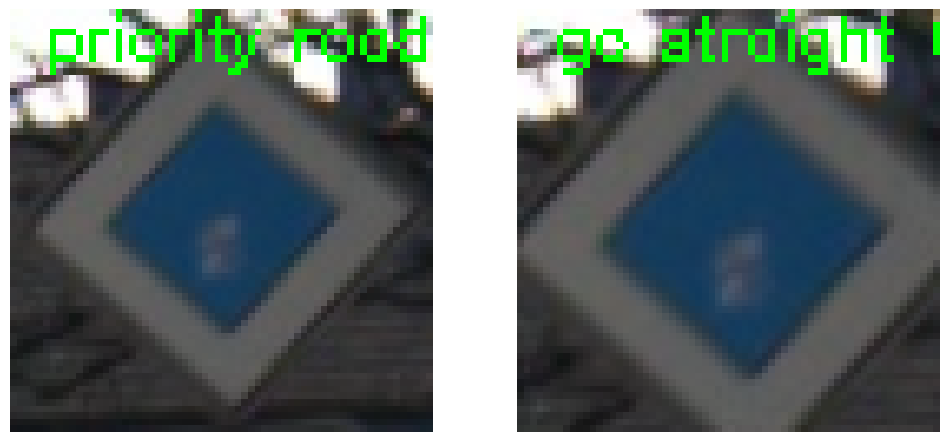

In [26]:
for image_data in set(wrong_datas):   
    draw_image_with_result_boxes(image_data)
    draw_cropped_boxes(image_data)
